In [1]:
import warnings
warnings.filterwarnings("ignore") 

import pandas as pd

from datetime import datetime,date
from causalnex.structure import StructureModel
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.network import BayesianNetwork
from causalnex.structure.notears import from_pandas

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler

from IPython.display import Image

import pickle


In [2]:
import sys
sys.path.append("../scripts/")
from data_cleaner import DataCleaner
cleaner = DataCleaner()

In [3]:
df  = pd.read_csv('../data/merged_df.csv')
clean_df = pd.read_csv('../data/clean_merged_df.csv')

In [4]:
# clean_df.head()

In [5]:
df["date"]=df["trip_start_time"].apply(lambda x: pd.to_datetime(x).date())
df["hour"]=df["trip_start_time"].apply(lambda x: pd.to_datetime(x).hour)
df.drop(columns="trip_start_time",inplace=True)

In [6]:
df = cleaner.find_distance(df,distance_col_name="distance_diff",trip_origin_col_names=["driver_lat","driver_lng"],trip_destination_col_names=["origin_lat","origin_lng"])


In [7]:
temp_df=df.copy()

In [8]:
convert_to_num_cols=["driver_lat","driver_lng","duration_min","origin_lat","origin_lng","hour","distance_diff"]
df = cleaner.convert_to_numbers(df,convert_to_num_cols)

convert_to_str_cols=["driver_id","driver_action","holiday"]
df = cleaner.convert_to_string(df,convert_to_str_cols)

convert_to_date_cols=["date"]
df = cleaner.convert_to_datetime(df,convert_to_date_cols)

# df[convert_to_num_cols] = df[convert_to_num_cols].apply(pd.to_numeric)


# for col in convert_to_str_cols:
#     df[col] = df[col].astype(str)

# df["date"] =  pd.to_datetime(df["date"])


In [9]:
df["fulfilled"] = (df["driver_action"] == "accepted") & (df["duration_min"] >=10)

In [10]:
# df.head()

In [11]:

def labe_encoder(df:pd.DataFrame,columns:list=None):
    if columns == None:
        # columns = df.select_dtypes(exclude = ['number','datetime'])
        columns = df.select_dtypes(exclude = ['number'])
    le = LabelEncoder()

    for col in columns:
        df[col] = le.fit_transform(df[col])

    return df

In [12]:
# df = cleaner.label_encoder(df)
df = labe_encoder(df)


In [13]:
driver_loc=df[["driver_lat","driver_lng"]]
request_loc=df[["origin_lat","origin_lng"]]

In [14]:
# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=50,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [15]:
# do clustering
kmeans.fit(driver_loc)
# save results
driver_labels = kmeans.labels_

In [16]:
# do clustering
kmeans.fit(request_loc)
# save results
request_labels = kmeans.labels_

In [17]:
df["driver_loc"]=driver_labels
df["request_loc"]=request_labels

In [1]:
# df.head()

In [21]:
temp_2 = df.copy()

In [20]:
df.drop(columns=["duration_min","order_id","driver_id","id","driver_lat","driver_lng","origin_lat","origin_lng"],inplace=True)
# df.rename(columns={"driver_id":"driver"},inplace=True)

## testing  features 

(pass this section)

In [72]:
# make a copy of dataframe
scaled_features = df.copy()

col_names = ['duration_min', 'distance_diff']
features = scaled_features[col_names]

# Use scaler of choice; here Standard scaler is used
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_names] = features

df = scaled_features.copy()

In [ ]:

sm = from_pandas(df)

In [120]:
sm_enh = from_pandas(df, tabu_edges=[("distance_diff","driver_loc")],tabu_parent_nodes=["driver_action"],tabu_child_nodes=["date","hour"], w_threshold=0.7)

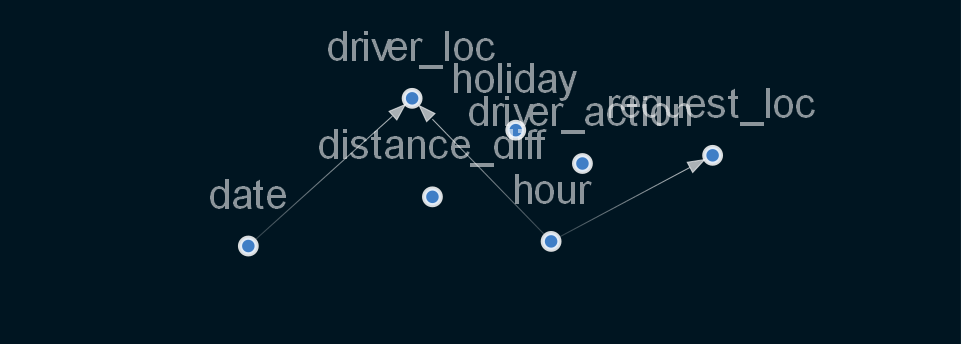

In [121]:
viz = plot_structure(
    sm_enh,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp'
)
Image(viz.draw(format='png'))

In [122]:
sm_enh.add_edge("distance_diff", "driver_action")
sm_enh.add_edge("date", "driver_action")
sm_enh.add_edge("date", "holiday")
sm_enh.add_edge("hour", "driver_action")
sm_enh.add_edge("request_loc", "distance_diff")
sm_enh.add_edge("driver_loc", "distance_diff")
sm_enh.add_edge("distance_diff", "driver_action")

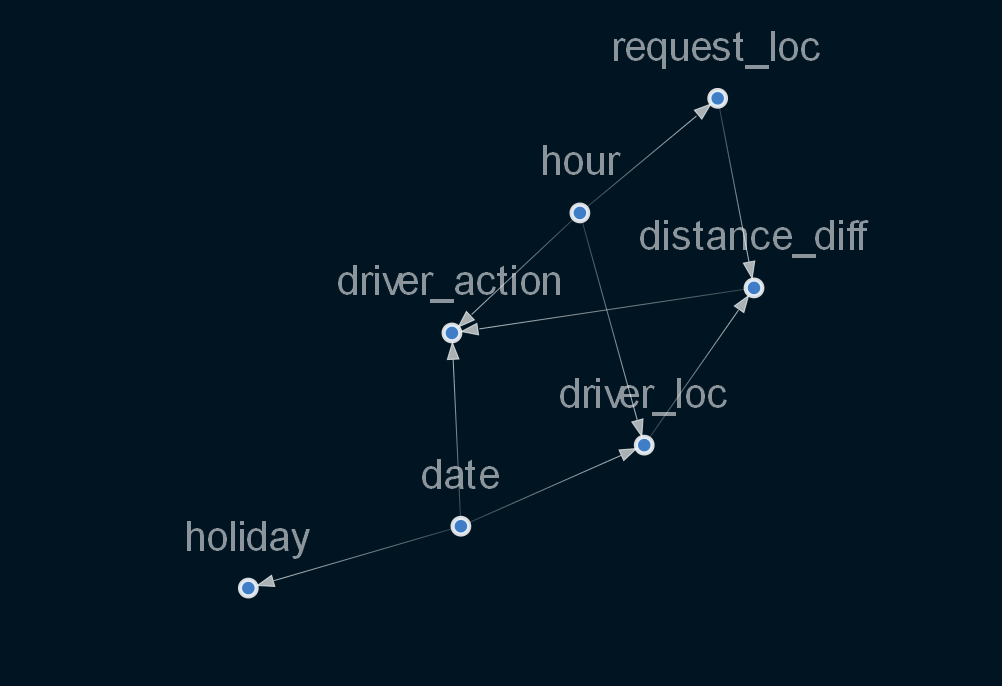

In [123]:
viz = plot_structure(
    sm_enh,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp'
)
Image(viz.draw(format='png'))

Exporting our findings

In [127]:
# with open('../models/sm.pkl', 'wb') as structural_model:
#   pickle.dump(sm, structural_model)


# import networkx as nx

# nx.drawing.nx_pydot.write_dot(sm_enh, '../doc/graph.dot')

## work with cleaned

In [61]:
cleaned_driver_loc=clean_df[["driver_lat","driver_lng"]]
cleaned_request_loc=clean_df[["origin_lat","origin_lng"]]

In [62]:
# do clustering
kmeans.fit(cleaned_request_loc)
# save results
cleaned_request_labels = kmeans.labels_

# do clustering
kmeans.fit(cleaned_driver_loc)
# save results
cleaned_driver_labels = kmeans.labels_

In [63]:
clustered_df=clean_df.copy()

clustered_df["driver_loc"]=cleaned_driver_labels
clustered_df["request_loc"]=cleaned_request_labels

In [64]:
clustered_df.drop(columns=["order_id","driver_lat","driver_lng","origin_lat","origin_lng","action_count"],inplace=True)
# clustered_df.rename(columns={"driver_id":"driver"},inplace=True)

In [65]:
clustered_df["month"]=clustered_df["trip_start_time"].apply(lambda x: pd.to_datetime(x).month)
clustered_df["day"]=clustered_df["trip_start_time"].apply(lambda x: pd.to_datetime(x).day)
clustered_df["hour"]=clustered_df["trip_start_time"].apply(lambda x: pd.to_datetime(x).hour)
clustered_df["minute"]=clustered_df["trip_start_time"].apply(lambda x: pd.to_datetime(x).minute)
clustered_df.drop(columns="trip_start_time",inplace=True)

In [66]:
clustered_df=labe_encoder(clustered_df,["holiday","driver_action","fulfilled","weekend"])

In [29]:
# clustered_df.head()

In [67]:
no_edges=[("fulfilled","duration_min"),("fulfilled","driver_loc"),("driver_action","driver_loc"),("driver_action","distance_diff"),("driver_action","duration_min")]
sm_enhanced = from_pandas(clustered_df,tabu_child_nodes=["month","day","hour","minute"])


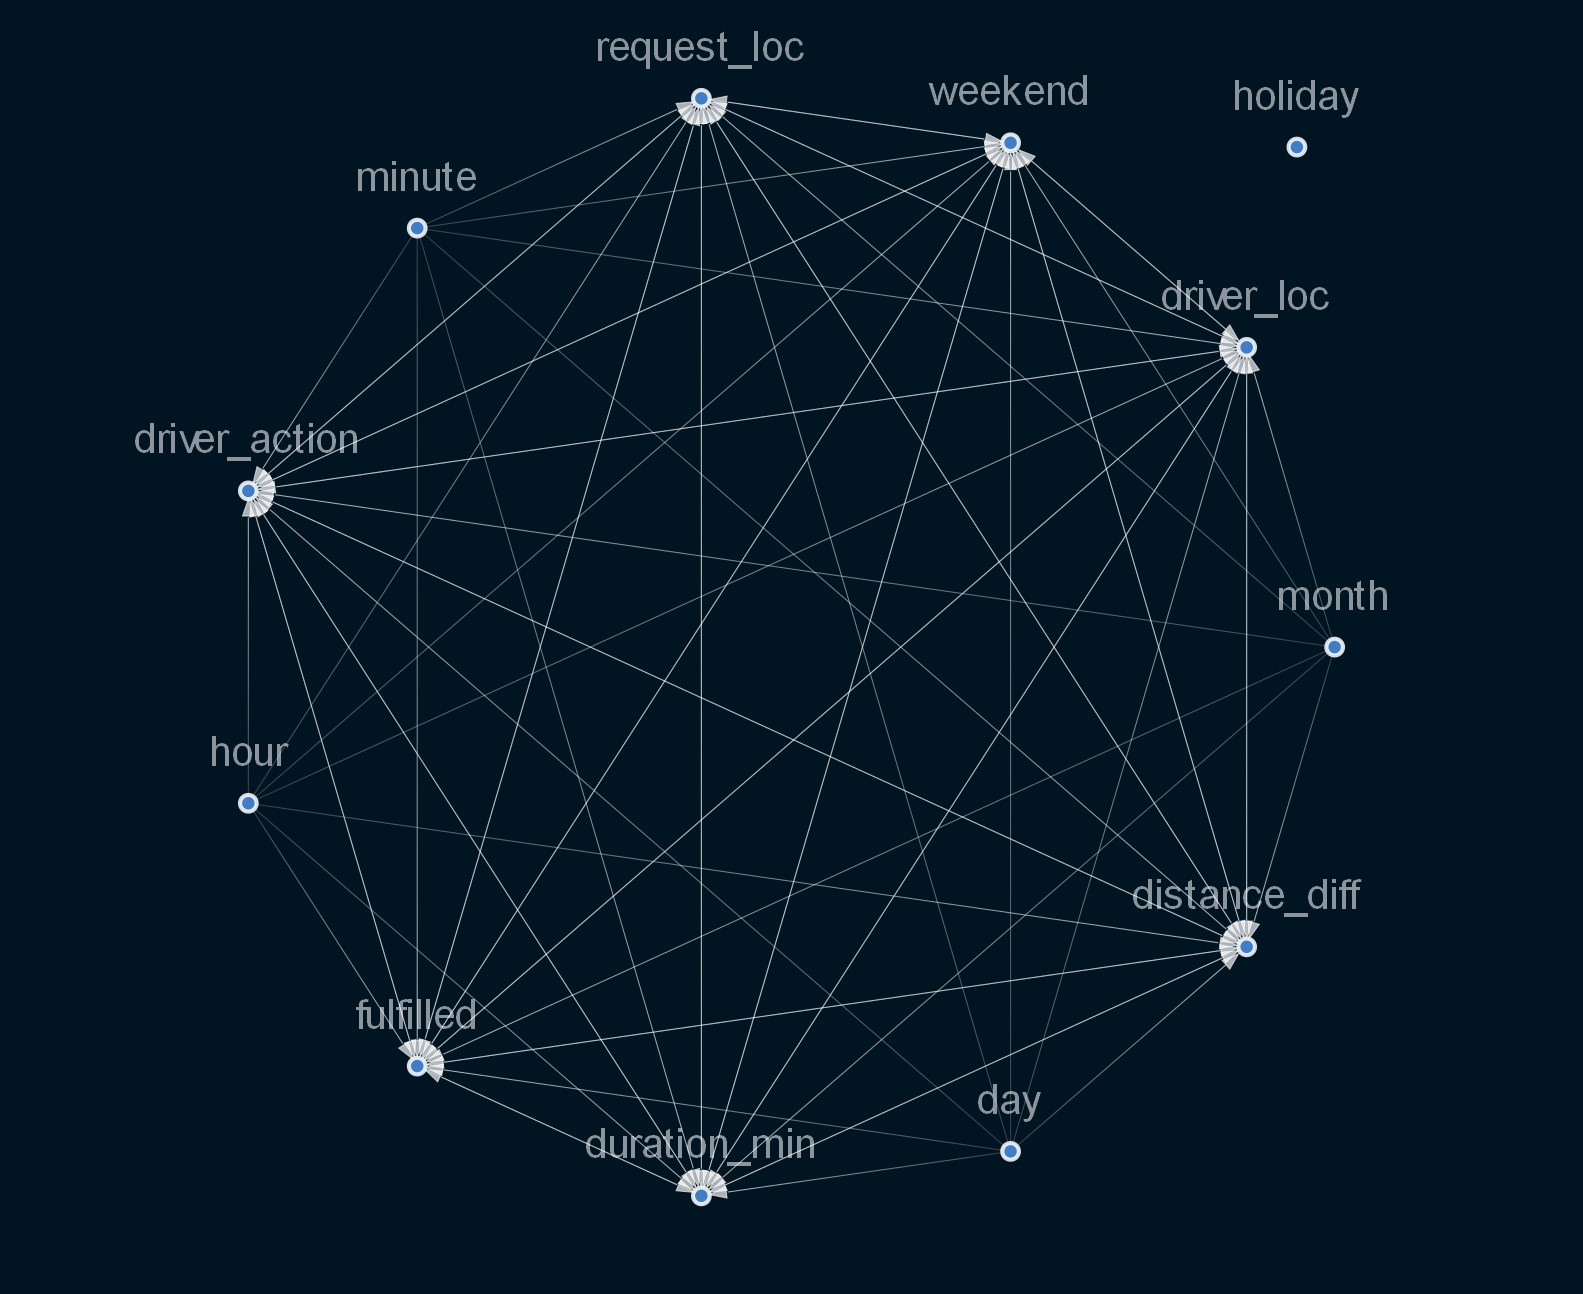

In [31]:
viz = plot_structure(
    sm_enhanced,
    graph_attributes={"scale": "0.8"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog="circo"
)
Image(viz.draw(format='png'))

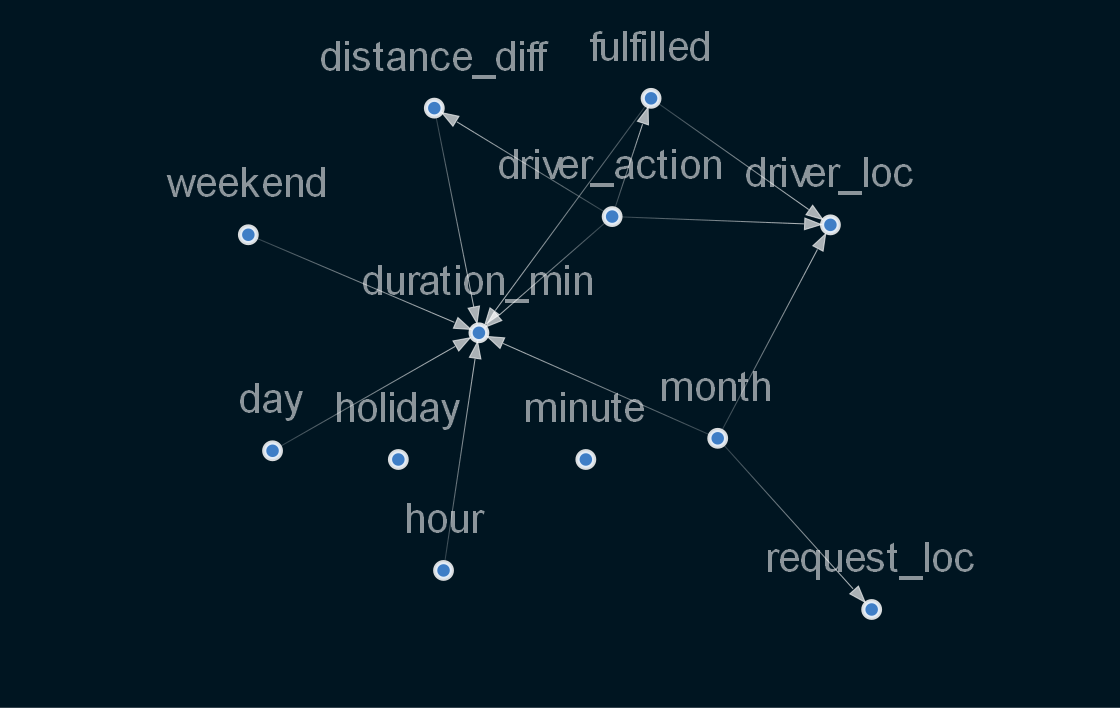

In [68]:
sm_enhanced.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm_enhanced,
    graph_attributes={"scale": "0.7","fontsize":"small"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [69]:
sm_enhanced.remove_edge("driver_action","distance_diff")
sm_enhanced.remove_edge("driver_action","driver_loc")
sm_enhanced.remove_edge("fulfilled","driver_loc")

In [70]:
sm_enhanced.add_edge("distance_diff", "driver_action")
sm_enhanced.add_edge("day", "driver_action")
sm_enhanced.add_edge("hour", "driver_action")
sm_enhanced.add_edge("request_loc", "distance_diff")
sm_enhanced.add_edge("driver_loc", "distance_diff")
sm_enhanced.add_edge("distance_diff", "driver_action")

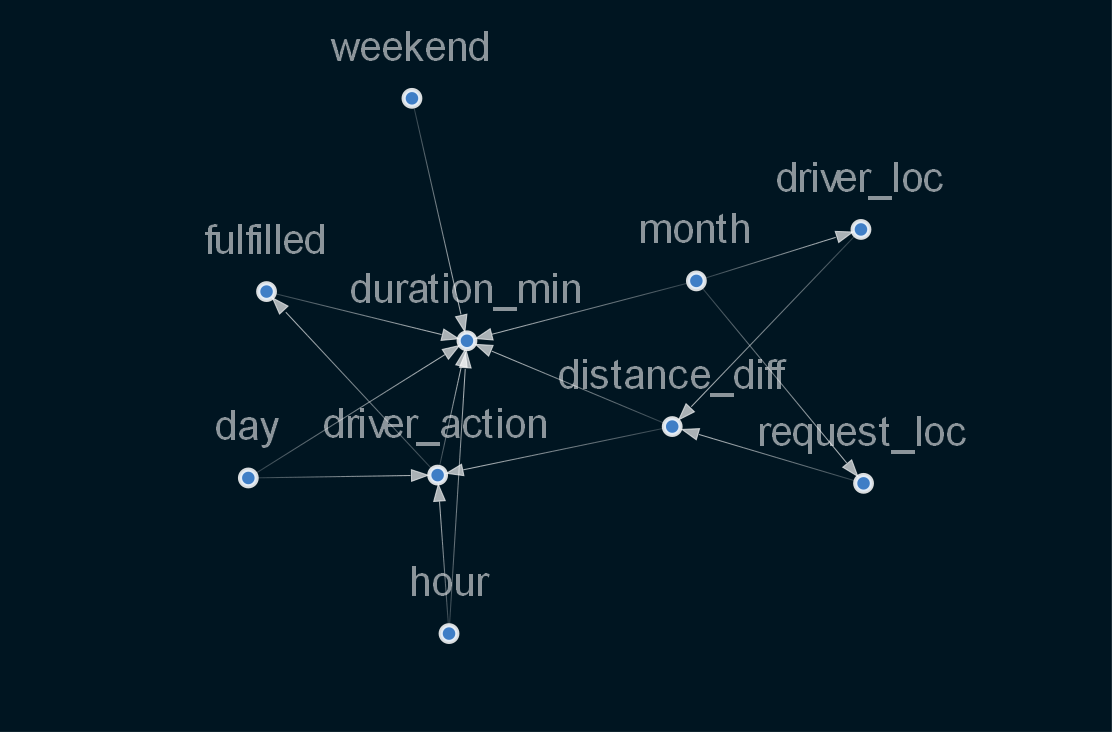

In [71]:
sm_enhanced = sm_enhanced.get_largest_subgraph()
viz = plot_structure(
    sm_enhanced,
    graph_attributes={"scale": "0.7","fontsize":"small"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [37]:
# clustered_df.head()

In [72]:
bn = BayesianNetwork(sm_enhanced)

In [73]:
from causalnex.discretiser import Discretiser

discretised_data = clustered_df.copy()

discretised_data["duration_min"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["duration_min"].values)
discretised_data["distance_diff"] = Discretiser(method="fixed",
                          numeric_split_points=[5]).transform(discretised_data["distance_diff"].values)
discretised_data["month"] = Discretiser(method="fixed",
                          numeric_split_points=[4,8]).transform(discretised_data["month"].values)
discretised_data["day"] = Discretiser(method="fixed",
                          numeric_split_points=[10,20]).transform(discretised_data["day"].values)
discretised_data["minute"] = Discretiser(method="fixed",
                          numeric_split_points=[30]).transform(discretised_data["minute"].values)
discretised_data["hour"] = Discretiser(method="fixed",
                          numeric_split_points=[8,16]).transform(discretised_data["hour"].values)

In [74]:
fullfilled_map = {0: "yes", 1: "no"}
holiday_map = {0: "no", 1: "yes"}
weekend_map = {0: "no", 1: "yes"}
driver_action_map = {0: "accepted", 1: "rejected"}

hour_map = {0:"early",1:"working_hour",2:"late"}
distance_map = {0:"near",1:"far"}
duration_map = {0:"short",1:"valid"}


discretised_data["fulfilled"] = discretised_data["fulfilled"].map(fullfilled_map)
discretised_data["holiday"] = discretised_data["holiday"].map(holiday_map)
discretised_data["weekend"] = discretised_data["weekend"].map(weekend_map)
discretised_data["driver_action"] = discretised_data["driver_action"].map(driver_action_map)
discretised_data["hour"] = discretised_data["hour"].map(hour_map)
discretised_data["distance_diff"] = discretised_data["distance_diff"].map(distance_map)
discretised_data["duration_min"] = discretised_data["duration_min"].map(duration_map)

In [75]:
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

In [76]:
bn = bn.fit_node_states(discretised_data)

In [77]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [78]:
bn.cpds["fulfilled"]

driver_action,accepted,rejected
fulfilled,,
no,0.917393,0.001802
yes,0.082607,0.998198


In [79]:
discretised_data.loc[18, discretised_data.columns != 'fulfilled']

distance_diff            near
duration_min            valid
holiday                    no
driver_action        accepted
weekend                    no
driver_loc                 35
request_loc                16
month                       1
day                         0
hour             working_hour
minute                      0
Name: 18, dtype: object

In [80]:
predictions = bn.predict(discretised_data, "fulfilled")

In [81]:
print(f"The prediction is '{predictions.loc[18, 'fulfilled_prediction']}'")

The prediction is 'no'


In [82]:

print(f"The ground truth is '{discretised_data.loc[18, 'fulfilled']}'")

The ground truth is 'no'


In [83]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "fulfilled")
print(auc)

0.9232273406906373


### Querying 

In [84]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals["fulfilled"]

{'no': 0.8944822251311699, 'yes': 0.10551777486882964}

In [85]:
import numpy as np

labels, counts = np.unique(discretised_data["fulfilled"], return_counts=True)
list(zip(labels, counts))

[('no', 23750), ('yes', 2742)]

## Marginal observations

In [86]:

marginals_short = ie.query({"distance_diff": "near"})
marginals_long = ie.query({"distance_diff": "far"})
print("Marginal driver_action | near distance", marginals_short["driver_action"])
print("Marginal driver_action | far distance", marginals_long["driver_action"])

Marginal driver_action | near distance {'accepted': 0.97673869448892, 'rejected': 0.02326130551107984}
Marginal driver_action | far distance {'accepted': 0.9726848982609052, 'rejected': 0.027315101739094766}


## DoCalculus

In [57]:
# testing do calculus before getting to action 

print("distribution before do", ie.query()["fulfilled"])
ie.do_intervention("fulfilled",
                   {'yes': 1.0,
                    'no': 0.0})
print("distribution after do", ie.query()["fulfilled"])

distribution before do {'no': 0.8938851582274379, 'yes': 0.106114841772562}
distribution after do {'no': 0.0, 'yes': 0.9999999999999997}


In [58]:
ie.reset_do("fulfilled")

In [87]:
# what if all drivers were in 5km of the request

print("marginal fulfilled", ie.query()["fulfilled"])
ie.do_intervention("distance_diff",
                   {'near': 1.0,
                    'far': 0.0})
print("updated marginal fulfilled", ie.query()["fulfilled"])
ie.reset_do("distance_diff")


marginal fulfilled {'no': 0.8944822251311699, 'yes': 0.10551777486882964}
updated marginal fulfilled {'no': 0.8960951381925741, 'yes': 0.1039048618074261}


In [90]:
# what if all drivers were in 5km of the request

print("marginal action", ie.query()["driver_action"])
ie.do_intervention("distance_diff",
                   {'near': 1.0,
                    'far': 0.0})
print("updated marginal actions", ie.query()["driver_action"])
ie.reset_do("distance_diff")

marginal action {'accepted': 0.9749770861510164, 'rejected': 0.025022913848985442}
updated marginal actions {'accepted': 0.97673869448892, 'rejected': 0.023261305511079876}


In [94]:
print("marginal fulfilled", ie.query()["duration_min"])


marginal fulfilled {'short': 0.1035654907246272, 'valid': 0.8964345092753737}


In [ ]:
print("marginal fulfilled", ie.query()["fulfilled"])
ie.do_intervention("distance_diff",
                   {'near': 1.0,
                    'far': 0.0})
ie.do_intervention("duration_min",
                   {'valid': 1.0,
                    'short': 0.0})
print("updated marginal fulfilled", ie.query()["fulfilled"])
ie.reset_do("distance_diff")
ie.reset_do("duration_min")

In [98]:
print("marginal actions", ie.query()["driver_action"])
ie.do_intervention("hour",
                   {'early': 1.0,
                    'late': 0.0,
                    'working_hour': 0.0})
print("updated marginal actionons", ie.query()["driver_action"])

ie.reset_do("hour")


marginal actions {'accepted': 0.9749770861510164, 'rejected': 0.025022913848985442}
updated marginal actionons {'accepted': 0.9342985342234652, 'rejected': 0.06570146577653518}


In [99]:
print("marginal actions", ie.query()["driver_action"])
ie.do_intervention("hour",
                   {'early': 0.0,
                    'late': 1.0,
                    'working_hour': 0.0})
print("updated marginal actionons", ie.query()["driver_action"])

ie.reset_do("hour")

marginal actions {'accepted': 0.9749770861510164, 'rejected': 0.025022913848985442}
updated marginal actionons {'accepted': 0.9707756740930668, 'rejected': 0.029224325906933357}


In [100]:
print("marginal actions", ie.query()["driver_action"])
ie.do_intervention("hour",
                   {'early': 0.0,
                    'late': 0.0,
                    'working_hour': 1.0})
print("updated marginal actionons", ie.query()["driver_action"])

ie.reset_do("hour")

marginal actions {'accepted': 0.9749770861510164, 'rejected': 0.025022913848985442}
updated marginal actionons {'accepted': 0.9772840576960751, 'rejected': 0.022715942303925776}


## Train ML models

In [102]:
def inverse_mapping(f):
    return f.__class__(map(reversed, f.items()))

In [108]:
test_df=test.copy()
train_df=train.copy()

rev_fullfilled_map= inverse_mapping(fullfilled_map)
rev_holiday_map= inverse_mapping(holiday_map)
rev_weekend_map= inverse_mapping(weekend_map)
rev_driver_action_map= inverse_mapping(driver_action_map)
rev_hour_map= inverse_mapping(hour_map)
rev_distance_map= inverse_mapping(distance_map)
rev_duration_map= inverse_mapping(duration_map)


test_df["fulfilled"] = test_df["fulfilled"].map(rev_fullfilled_map)
test_df["holiday"] = test_df["holiday"].map(rev_holiday_map)
test_df["weekend"] = test_df["weekend"].map(rev_weekend_map)
test_df["driver_action"] = test_df["driver_action"].map(rev_driver_action_map)
test_df["hour"] = test_df["hour"].map(rev_hour_map)
test_df["distance_diff"] = test_df["distance_diff"].map(rev_distance_map)
test_df["duration_min"] = test_df["duration_min"].map(rev_duration_map)

train_df["fulfilled"] = train_df["fulfilled"].map(rev_fullfilled_map)
train_df["holiday"] = train_df["holiday"].map(rev_holiday_map)
train_df["weekend"] = train_df["weekend"].map(rev_weekend_map)
train_df["driver_action"] = train_df["driver_action"].map(rev_driver_action_map)
train_df["hour"] = train_df["hour"].map(rev_hour_map)
train_df["distance_diff"] = train_df["distance_diff"].map(rev_distance_map)
train_df["duration_min"] = train_df["duration_min"].map(rev_duration_map)


In [133]:
X_train=train_df.loc[:, train_df.columns != "fulfilled"]
X_test=test_df.loc[:, test_df.columns != "fulfilled"]

y_train=train_df[["fulfilled"]]
y_test=test_df[["fulfilled"]]

In [134]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=2, random_state=0)

# forest = RandomForestClassifier(criterion='gini',
#                                  n_estimators=5,
#                                  random_state=1,
#                                  n_jobs=2)

forest.fit(X_train, y_train)
# RandomForestClassifier(...)
pred_y=forest.predict(X_test)

In [135]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred_y)
# clf.score(test_x)

0.9207547169811321

In [166]:
# discretised_data.head()